In [119]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

In [2]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import *

In [3]:
import os
import scipy.spatial.distance as ssd

In [ ]:
#import sys
#!conda install --yes --prefix {sys.prefix} pandas

In [4]:
%matplotlib inline

# Functions

Those functions can be found in this file:

functions_for_clusterisation.py

In [5]:
class filename_maker():
    """
    just class for creating fixed names for files
    """
    def __init__(self, chain, segment, specie):
        self.chain = chain
        self.segment = segment
        self.specie = specie
        self.workdir = ''

    def add_dir(self, workdir):
        self.workdir = workdir

    def get_name(self, name):
        return os.path.join(self.workdir, 'TR{}{}_{}.{}.txt'.format(self.chain, self.segment, self.specie, name))

In [7]:
def find_distances(dists, segment, specie, chain):
    w_dists = dists[(dists['segment'] == segment) & (dists['species']==specie)]
    w_dists = pd.DataFrame(w_dists[w_dists['gene'] == 'TR{}'.format(chain.upper())], columns=['id.1', 'id.2', 'segm.score'])
    w_dists['segm.score'] = w_dists['segm.score']*-1
    w_dists = w_dists.pivot(index='id.1', columns='id.2', values='segm.score')
    return w_dists

In [21]:
def compute_clusters(dist, cutoff=350, method='ward', use_plot=True, figsize_x=8, figsize_y=14):
    work_index = dist.index
    #just in case: if you use linkage on dist without ssd.squareform, you'll get different clusters
    #linkage asks condensed matrix as input (all elements under first diagonal are zeroes)
    #somehow usage of np.triu also results with different clusters.
    #https://stackoverflow.com/questions/36520043/triangle-vs-square-distance-matrix-for-hierarchical-clustering-python
    work_Z = linkage(ssd.squareform(dist), method)
    work_clusters = fcluster(work_Z, cutoff, criterion='distance')
    df_clusters = pd.DataFrame(sorted(list(zip(work_clusters, work_index)), 
                                      key=lambda x: x[0]), columns=['cluster', 'id'])
    if use_plot is True:
        fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
        ax = dendrogram(work_Z,
                        color_threshold=cutoff,
                        leaf_font_size=10,
                        labels = work_index,
                        orientation="left")
        plt.show()
    return df_clusters

# Clusterisation

## Homo Sapiens

In [ ]:
distances = pd.read_table('segm_score.txt')

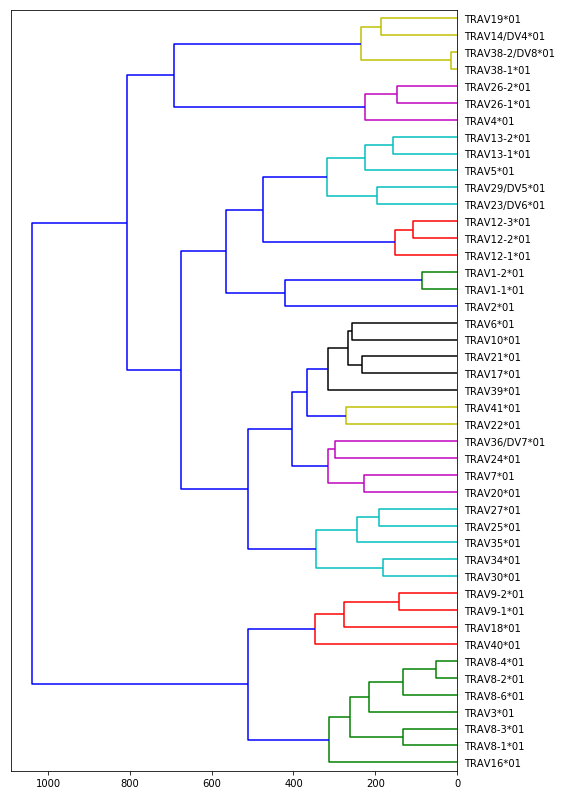

In [22]:
distances_a_hs = find_distances(distances, 'V', 'HomoSapiens', 'A')
filemaker_a_hs = filename_maker('A', 'V', 'HomoSapiens')
filemaker_a_hs.add_dir('position_analysis')
compute_clusters(distances_a_hs, cutoff=350).to_csv(filemaker_a_hs.get_name('df_clusters'), sep='\t', index=None)

I guess we should check, whether current threshold is good enough: we can see strange clusters (like cluster with TRAV6\*01, TRAV10\*01, TRAV21\*01, TRAV17\*-1, TRAV39\*01) 

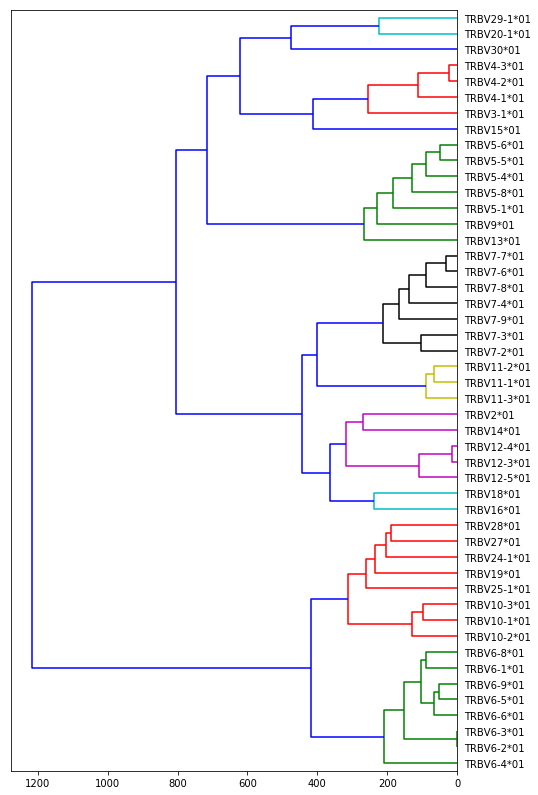

In [10]:
distances_b_hs = find_distances(distances, 'V', 'HomoSapiens', 'B')
filemaker_b_hs = filename_maker('B', 'V', 'HomoSapiens')
filemaker_b_hs.add_dir('position_analysis')
compute_clusters(distances_b_hs, cutoff=350).to_csv(filemaker_b_hs.get_name('df_clusters'), sep='\t', index=None)

## Mus Musculus

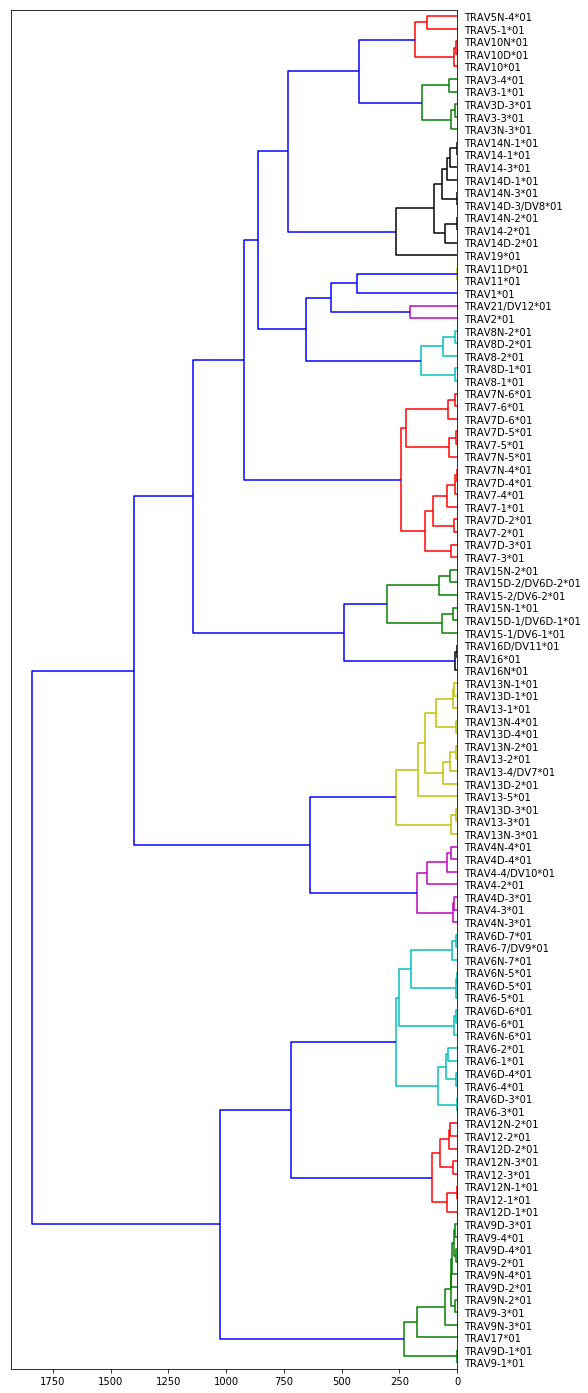

In [15]:
distances_a_mus = find_distances(distances, 'V', 'MusMusculus', 'A')
filemaker_a_mus = filename_maker('A', 'V', 'MusMusculus')
filemaker_a_mus.add_dir('position_analysis')
compute_clusters(distances_a_mus, cutoff=350, figsize_y=25).to_csv(filemaker_a_mus.get_name('df_clusters'), sep='\t', index=None)

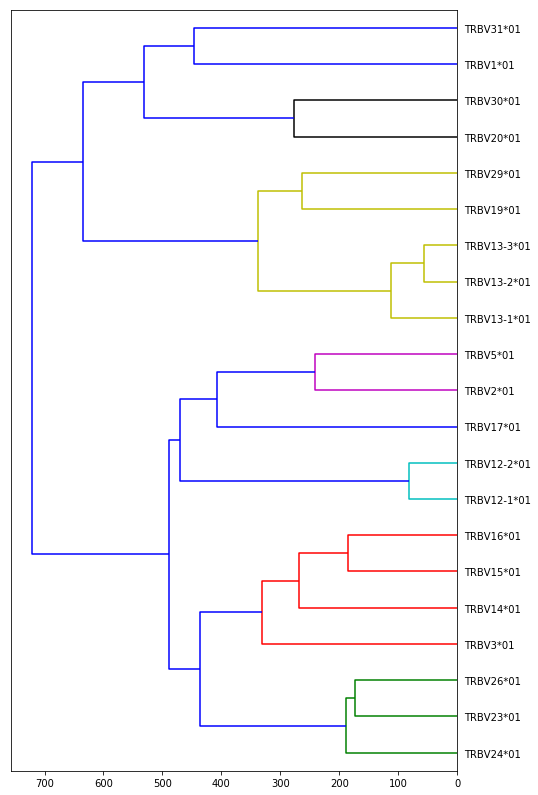

In [12]:
distances_b_mus = find_distances(distances, 'V', 'MusMusculus', 'B')
filemaker_b_mus = filename_maker('B', 'V', 'MusMusculus')
filemaker_b_mus.add_dir('position_analysis')
compute_clusters(distances_b_mus, cutoff=350).to_csv(filemaker_b_mus.get_name('df_clusters'), sep='\t', index=None)

Same situation as with TRAV *Homo Sapiens* clusters..

What structures do we have?

Let's download final.annotations.txt from https://github.com/antigenomics/tcr-pmhc-study/blob/master/preprocessing/output/final.annotations.txt

In [49]:
import re

In [198]:
def read_clusters(inp_file, modificate_cluster_names=True):
    clusters = pd.read_table(inp_file)
    if modificate_cluster_names is True:
        clusters['cluster'] = clusters['cluster'].astype(str).str.cat(clusters['id'].str.get(2))
    return(clusters)


def capitalize(name):
    rx = re.compile(r'_(\w)')
    
    def repl(m):
        char = m.group(1)
        return char.upper()
    
    return rx.sub(repl, name)


def read_final_annotations(inp_file):
    final_annot = pd.read_table(inp_file, usecols=['pdb_id', 'species', 'tcr_gene', 'tcr_v_allele'])
    #*digit means 
    final_annot['species'] = final_annot['species'].apply(capitalize)
    final_annot['tcr_v_allele'] = final_annot['tcr_v_allele'].str.replace(r'\*\d+', '*01')
    final_annot['tcr_v_allele'] = final_annot['tcr_v_allele'].str.replace('_', '/')
    final_annot = final_annot.drop_duplicates(keep='first').reset_index(drop=True)
    final_annot.columns = ['pdb_id', 'species', 'gene', 'id']
    return final_annot


#just little function to compute number of genes/clusters, represented in structures
def get_cluster_info(clusters, annot, specie, segment, workdir=''):
    
    
    #unpaired, paired, unpaired_clusters, paired_clusters
    #unpaired
    genes = ['TRA', 'TRB']
    work_annot = annot[annot['species'] == specie]
    work_annot = pd.merge(work_annot, clusters, on=['id'], how='left')
    for gene in genes:
        
        w_annot = work_annot[work_annot['gene'] == gene]
        
        unpaired_annot = pd.DataFrame(w_annot.groupby('id').count()['pdb_id']) #unpaired
        unpaired_annot['id'] = unpaired_annot.index
        unpaired_annot.columns = ['count', 'id']
        #merge by='outer' to get genes that are not represented in structures
        unpaired_annot = pd.merge(pd.DataFrame(unpaired_annot, columns=['id', 'count']), clusters[clusters['cluster'].str.get(-1) == gene[-1]], on=['id'], how='left')
        #use next row if you merged by='outer'
        #unpaired_annot['count'] = unpaired_annot['count'].fillna(0)
        unpaired_annot['id_num'] = unpaired_annot['id'].str.replace(r'{}{}'.format(gene, segment), '')
        unpaired_annot['id_num'] = unpaired_annot['id_num'].str.replace(r'[\*\-/].*', '') + '|'
        unpaired_annot.to_csv(os.path.join(workdir, '{}{}_{}.unpaired.txt'.format(gene, segment, specie)), sep='\t', index=None)
        
        #unpaired_annot = unpaired_annot.drop(columns=['pdb_id'])
        unpaired_annot_clusters = pd.DataFrame(w_annot.groupby('cluster').count()['pdb_id']) #unpaired_clusters
        unpaired_annot_clusters = unpaired_annot_clusters.reset_index()
        unpaired_annot_clusters.columns = ['cluster', 'count']
        unpaired_annot_clusters.to_csv(os.path.join(workdir, '{}{}_{}.unpaired_clusters.txt'.format(gene, segment, specie)), sep='\t', index=None)
    
    #paired
    w_annot_alpha = work_annot[work_annot['gene'] == 'TRA']
    w_annot_alpha = pd.DataFrame(w_annot_alpha, columns=['pdb_id', 'id', 'cluster'])
    w_annot_alpha.columns = ['pdb_id', 'alpha_id', 'alpha_cluster']
    
    w_annot_beta = work_annot[work_annot['gene'] == 'TRB']
    w_annot_beta = pd.DataFrame(w_annot_beta, columns=['pdb_id', 'id', 'cluster'])
    w_annot_beta.columns = ['pdb_id', 'beta_id', 'beta_cluster']
    
    paired_annot = pd.merge(w_annot_alpha, w_annot_beta, on=['pdb_id'], how='left')
    paired_annot['alpha_beta'] = paired_annot['alpha_id'] + '|' + paired_annot['beta_id']
    paired_annot['alpha_beta_clusters'] = paired_annot['alpha_cluster'] + '|' + paired_annot['beta_cluster']
    
    paired_annot_count = pd.DataFrame(paired_annot.groupby('alpha_beta').count()['pdb_id']).reset_index()
    paired_annot_count.columns = ['alpha_beta', 'count']
    paired_annot_count = pd.DataFrame(pd.merge(paired_annot_count,
                                               paired_annot.drop_duplicates(subset='alpha_beta',
                                                                            keep='first'),
                                               on=['alpha_beta'],
                                               how='left'), columns = ['alpha_beta', 'count', 'alpha_beta_clusters'])

    paired_annot_count.to_csv(os.path.join(workdir, 'TR{}_{}.paired.txt'.format(segment, specie)), sep='\t', index=None)
    paired_annot_clusters_count = pd.DataFrame(paired_annot.groupby('alpha_beta_clusters').count()['pdb_id']).reset_index()
    paired_annot_clusters_count.columns = ['alpha_beta_clusters', 'count']
    paired_annot_clusters_count.to_csv(os.path.join(workdir, 'TR{}_{}.paired_clusters.txt'.format(segment, specie)), sep='\t', index=None)
    
    
    
annot = read_final_annotations('final.annotations.txt')
clusters_hs = read_clusters(filemaker_a_hs.get_name('df_clusters')).append(read_clusters(filemaker_b_hs.get_name('df_clusters')), ignore_index=True)
get_cluster_info(clusters_hs, annot, 'HomoSapiens', 'V', 'position_analysis')
clusters_mus = read_clusters(filemaker_a_mus.get_name('df_clusters')).append(read_clusters(filemaker_b_mus.get_name('df_clusters')), ignore_index=True)
get_cluster_info(clusters_mus, annot, 'MusMusculus', 'V', 'position_analysis')

Now we have clusters. Pictures will be made using ggplot in R (pdb_clusters.R)